In [ ]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import math
import nltk

In [ ]:
data = pd.read_csv('IMDB Dataset.csv')
data


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(data, *['sentiment'], **{})
chart

In [ ]:
TAG_RE=re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('',text)

In [ ]:
def preprocess_text(sen):

#    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
#     in lowercase'''

    sentence = sen.lower()

     # Remove html tags
    sentence = remove_tags(sentence)

     # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

     # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

     # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    return sentence
data['review']=data['review'].apply(lambda cw : preprocess_text(cw))
data['review']

0        one of the other reviewers has mentioned that ...
1        a wonderful little production the filming tech...
2        i thought this was wonderful way to spend time...
3        basically there a family where little boy jake...
4        petter mattei love in the time of money is vis...
                               ...                        
49995    i thought this movie did down right good job i...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am catholic taught in parochial elementary s...
49998    i going to have to disagree with the previous ...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
data['review'] = data.review.apply(lemmatize_text)
data

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter mattei love time money visually stunnin...,positive
...,...,...
49995,thought movie right good job creative original...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary school nu...,negative
49998,going disagree previous comment side maltin on...,negative


<Axes: xlabel='sentiment', ylabel='count'>

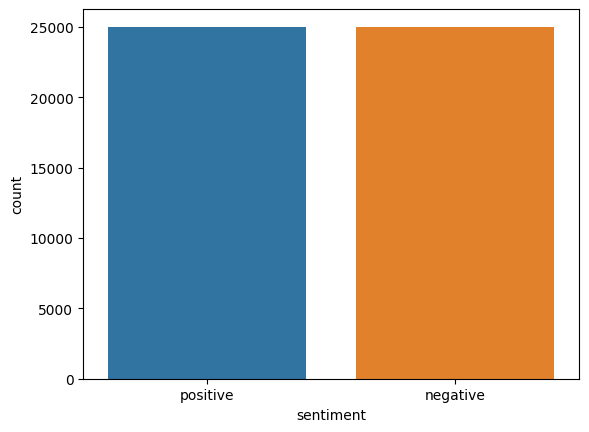

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data=data)

In [ ]:
reviews = data['review'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [ ]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, encoded_labels, stratify = encoded_labels)

In [ ]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = ''
embedding_dim = 100
max_length = 200 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok) #oov_token replace unknown words to '' (OutOfVocabulary)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [ ]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          300000    
                                                                 
 bidirectional (Bidirection  (None, 128)               84480     
 al)                                                             
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 387601 (1.48 MB)
Trainable params: 387601 (1.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
num_epochs = 5
history = model.fit(train_padded, train_labels, epochs=num_epochs, verbose=1, validation_split=0.1)

Epoch 1/5
1055/1055 [==============================] - 293s 273ms/step - loss: 0.3882 - accuracy: 0.8256 - val_loss: 0.3263 - val_accuracy: 0.8659
Epoch 2/5
1055/1055 [==============================] - 279s 264ms/step - loss: 0.2831 - accuracy: 0.8854 - val_loss: 0.3192 - val_accuracy: 0.8645
Epoch 3/5
1055/1055 [==============================] - 277s 263ms/step - loss: 0.2515 - accuracy: 0.8983 - val_loss: 0.3343 - val_accuracy: 0.8616
Epoch 4/5
1055/1055 [==============================] - 278s 263ms/step - loss: 0.2244 - accuracy: 0.9125 - val_loss: 0.3525 - val_accuracy: 0.8549
Epoch 5/5
1055/1055 [==============================] - 271s 257ms/step - loss: 0.1972 - accuracy: 0.9237 - val_loss: 0.3512 - val_accuracy: 0.8576


In [ ]:
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(test_labels,pred_labels))

391/391 [==============================] - 34s 83ms/step
Accuracy of prediction on test set :  0.86576


In [ ]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming",
            "I have never seen a terrible movie like this",
            "the movie plot is terrible but it had good acting"]
# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)
# pad the sequence
padded = pad_sequences(sequences, padding='post', maxlen=max_length)
# Get labels based on probability 1 if p>= 0.5 else 0
prediction = model.predict(padded)
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
for i in range(len(sentence)):
    print(sentence[i])
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
    print("Predicted sentiment : ",s)

1/1 [==============================] - 0s 86ms/step
The movie was very touching and heart whelming
Predicted sentiment :  Positive
I have never seen a terrible movie like this
Predicted sentiment :  Negative
the movie plot is terrible but it had good acting
Predicted sentiment :  Negative
